# Sea surface temperature characteristics of Australian Marine Parks

* **Compatibility:** Notebook currently compatible with the `NCI` environment
* **Products used:** `modis_oc_1d development` database
* **Requirements:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set: 
```
module use /g/data/v10/public/modules/modulefiles;
module load dea
```    
* **Prerequisites:** The [introduction_to_MODIS_oceancolor](./introduction_to_modis_oceancolour.ipynb) notebook

## Background

The Australian Government has established 60 marine parks around the country. Marine parks help conserve marine habitats and the marine species that live within and rely on these habitats. Marine parks also provide places for people to watch wildlife, dive, and go boating, snorkelling and fishing. Importantly, they create jobs in industries like fishing and tourism, and provide us with food and energy.

Understanding and monitoring the environmental characteristics of Australian marine parks can be challenging due to their remoteness and large sizes. Marine surveys and in-situ observation instruments can provide some environmental information, however these are often very expensive and lack spatial and/or temporal coverage.

### Digitial Earth Australia use case

Imagery from satellites such as [NASA's MODIS](https://terra.nasa.gov/about/terra-instruments/modis) and [NOAA's AVHRR](https://www.ospo.noaa.gov/Operations/POES/NOAA15/avhrr.html) is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring Australian marine parks. 

Satellite data can provide envrionmental information on water quality, sea surface temperature and primary productivity of Australian marine parks in a timely manner. Satellite data can also help detect and monitor harmful events such as algae blooms and marine heat waves occuring in Australian marine parks.

## Description

In this example, we use [IMOS](http://imos.org.au/) MODIS sea surface temperate (SST) data between 2002 and 2019 to characterise the SST properties of an Australian marine park. The worked example demonstrates how to:

1. Load in MODIS SST data
2. If there are island(s)/reef(s) within the marine park, create buffer(s) around them to mask out the shallow water
3. Conduct zonal statistics to obtain an overall SST daily time series
4. Calculate SST monthly and yearly time series
5. Calculate SST warming rates from the time series 
6. Plot the SST time-series and spatial and temporal variances
7. Identify extreme hot days
8. Calculate per-pixel SST long-term means, seasonal means and monthly means
9. Calculate per-pixel SST warming rates
10. Display the spatial distributions of the SST means with indication of observation frequency
11. Dispaly the spatial distributions of the SST warming rates with indication of statistical significance

## Getting started

To run this analysis, run all the cells in the notebook, starting with the [Load packages](#LoadPackages) cell.
    
After finishing the analysis, return to the [Analysis parameters](#AnalysisParameters) cell, modify some values (e.g. choose a different output crs or resolution or a different marine park) and re-run the analysis.

<a id='LoadPackages'></a>
## Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import fiona
import geopandas as gpd
import pandas as pd
import rasterio.features
import numpy as np
import shapefile as shpf
import scipy.ndimage as ndimage
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import shapely
import os

from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
from datacube.utils import geometry
from shapely.geometry import shape, mapping
from affine import Affine
from datetime import datetime
from osgeo import ogr

### The pad function (written by Eric Oliver) for linear interpolation of missing data in a time series

This function allows the user to specify the number of NaN observations over which to interpolate, and which to leave as NaNs. This is useful if you don't want to interpolate over a large number of consecutive missing values.

In [2]:
def pad(data, maxPadLength=False):
    '''
    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data           Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015
    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded

### The geometry_to_shapefile function for writting  polygon geometry to a shapefile

This function is used to write a polygon geometry to a ESRI shapefile

In [3]:
def geometry_to_shapefile(shapefileName,geom):
    # geom: shapely.geometry.polygon.Polygon

    # Define a polygon feature geometry with one attribute
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }

    # Write a new Shapefile
    with fiona.open(shapefileName, 'w', 'ESRI Shapefile', schema) as collection:
        ## If there are multiple geometries, put the "for" loop here
        collection.write({
            'geometry': mapping(geom),
            'properties': {'id': 1},
        })
    return

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

Note that `modis_oc_1d` is development product. It is on a different database server `agdcstaging-db.nci.org.au`, which means that your ~/.pgpass file will need to specify a password to connect to it as well.

In [4]:
config = {'db_hostname': 'agdcstaging-db.nci.org.au',
          'db_port': 6432,
          'db_database': 'dea_modis'}

dc = Datacube(config=config)

<a id='AnalysisParameters'></a>
### Analysis parameters
    
The following cell set important parameters for the analysis:
  
* `output_crs`: The original MODIS SST data are in WGS84 coordinate system ('EPSG:4326'). If you want to change coordinate system please specify this prameter (e.g., 'EPSG:3577').
* `resolution`: The desirable spatial resolution of the MODIS SST data (e.g., `(-1300,1300)`).
* `buffer_dist`: The distance (unit corresponds to the selected coordinate system) used to buffer the island/reefs to mask out the shallow water.
* `AMP_name`: The name of the selected Australian marine park; note that many AMPs are too large to run effectively and efficiently under the VDI environment
* `AMPs_path`: The polygon shapefile of all Australian marine parks
* `reefs_islands_path`: The polygon shapefile of all Australian islands/reefs
* `AMP_shp`: The temporary shapefile to store the selected marine park polygon
* `reefs_islands_shp`: The temporary shapefile to store the islands/reefs polygons within the selected marine park
* `buffer_shp`: The temporary shapefile to store the buffer polygon of the islands/reefs within the selected marine park

In [5]:
output_crs = 'EPSG:4326'
resolution = (-0.01,0.01)
buffer_dist = 0.01
AMP_name = 'Cartier Island'
AMPs_path = '../../shapefiles/CMR_2013_dissolved_wgs84.shp'
reefs_islands_path = '../../shapefiles/Australian_Reefs_Islands1_dissloved.shp'
AMP_shp = '../../shapefiles/marine_park.shp'
reefs_islands_shp = '../../shapefiles/reefs_islands.shp'
buffer_shp = '../../shapefiles/reefs_islands_buffer.shp'

## Prepare the polygon area for the analysis

We want to use a polygon to define our region of interest. This polygon is a modified version of the selected marine park (e.g., after masking out the shallow water areas). 

### Buffer the islands/reefs and erase the buffer from the marine park polygon

The erased polygon is used as the geometry to load the MODIS SST data

In [6]:
##open the polygon
driver = ogr.GetDriverByName("ESRI Shapefile")        
dataSource = driver.Open(AMPs_path, 0)
layer = dataSource.GetLayer()
spatialRef = layer.GetSpatialRef()
crs = geometry.CRS(spatialRef.ExportToWkt())

for feature in layer:
    name = feature.GetField("MPA_NAME")
    if name == AMP_name:
        print(name)
        geom = shapely.wkt.loads(feature.GetGeometryRef().ExportToWkt())        
        AMP_Geometry = geometry.Geometry(mapping(geom),crs=crs)

with fiona.open(reefs_islands_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        reefs_islands_Geometry = geometry.Geometry(first_geometry, crs=crs)

AMP_polygon = shape(AMP_Geometry) # the marine park polygon
# delete the temporary shapefiles so that new shapefles can be written
if os.path.exists(AMP_shp):
     driver.DeleteDataSource(AMP_shp)
if os.path.exists(reefs_islands_shp):
    driver.DeleteDataSource(reefs_islands_shp)
if os.path.exists(buffer_shp):
    driver.DeleteDataSource(buffer_shp)
#write the marine park polygon to a shapefile    
geometry_to_shapefile(AMP_shp,AMP_polygon)

intersect_geom =  reefs_islands_Geometry.intersection(AMP_Geometry)
if intersect_geom.is_empty: # islands/reefs polygons do not intersect the marine park polyon
    newGeom1 = mapping(AMP_polygon)
else:
    reefs_islands_polygon = shape(intersect_geom) # islands/reefs within the marine park
    buffer_polygon = shape(reefs_islands_polygon.buffer(buffer_dist)) # buffer the islands/reefs with a distance of the buffer_dist parameter
    newGeom = AMP_polygon.difference(buffer_polygon) # erase the buffer from the marine park polygon
    newGeom1 = mapping(newGeom)      
    #write the islands/reefs polygon and the buffer polygon to shapefiles  
    geometry_to_shapefile(reefs_islands_shp,reefs_islands_polygon)
    geometry_to_shapefile(buffer_shp,buffer_polygon)
    
marine_geom = geometry.Geometry(newGeom1, crs=crs) # the marine_geom geometry is used to load the MODIS data


Cartier Island


## Build query and load data

We will calculate the time taken to load the data as well.

In [7]:
query = {'geopolygon': marine_geom,
         'output_crs': output_crs,
         'resolution': resolution
         }

Here we do not specify a time parameter, meaning that all available observations will be returned.

If you want to load data for a long time period, you need to keep the bounding box for the query very small. Conversely, if you load a large area, you need to keep the time period short. This is to limit the amount of data that is loaded into memory at any one time.

In [8]:
time1 = datetime.now()
MODIS_data = dc.load(product='modis_oc_1d', measurements=(['sst']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:28:38.190132 to finish


### Create a mask for the area covered by the erased marine park polygon

We only want to keep data within the `marine_geom`, so we create a mask and remove any data outside this region, and any no-data values from the MODIS data.

In [9]:
mask = rasterio.features.geometry_mask([marine_geom.to_crs(MODIS_data.geobox.crs) for geoms in [marine_geom]],
                                           out_shape=MODIS_data.geobox.shape,
                                           transform=MODIS_data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
MODIS_data = MODIS_data.where(mask)
MODIS_data_cleaned = mask_invalid_data(MODIS_data)

### Check the loaded MODIS SST data

Note the extensive time dimension.

In [10]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:    (latitude: 14, longitude: 15, time: 6214)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude   (latitude) float64 -12.47 -12.48 -12.49 ... -12.58 -12.59 -12.6
  * longitude  (longitude) float64 123.5 123.5 123.5 123.5 ... 123.6 123.6 123.6
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:4326

### Plot a daily SST image
A quick check of the loaded data

<Figure size 432x360 with 0 Axes>

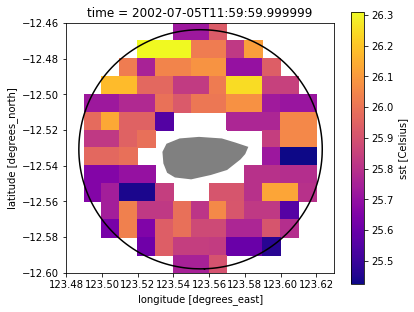

In [11]:
# calculate the aspect of the marine park extent, for the proper display of the SST image
h_w_ratio = round(MODIS_data_cleaned.latitude.size / MODIS_data_cleaned.longitude.size, 1)
width = 6
height = round(width * h_w_ratio)
plt.figure(figsize=(width,height))

if os.path.exists(reefs_islands_shp): 
    # plot the islands/reefs
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(figsize=(width,height),color='gray')

# plot the marine park outline
plt.plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
MODIS_data_cleaned.sst[1].plot(cmap='plasma')

## Calculate some zonal statistics

We want to get a timeseries of SST for the marine park based on the mean/max/min/std of all pixels.

In [12]:
MODIS_data_cleaned['sst_mean'] = MODIS_data_cleaned.sst.mean(dim=['longitude','latitude'])
MODIS_data_cleaned['sst_min'] = MODIS_data_cleaned.sst.min(dim=['longitude','latitude'])
MODIS_data_cleaned['sst_max'] = MODIS_data_cleaned.sst.max(dim=['longitude','latitude'])
MODIS_data_cleaned['sst_std'] = MODIS_data_cleaned.sst.std(dim=['longitude','latitude'])

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [13]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:    (latitude: 14, longitude: 15, time: 6214)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude   (latitude) float64 -12.47 -12.48 -12.49 ... -12.58 -12.59 -12.6
  * longitude  (longitude) float64 123.5 123.5 123.5 123.5 ... 123.6 123.6 123.6
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    sst_mean   (time) float32 26.897036 25.869576 26.680424 ... 26.299578 nan
    sst_min    (time) float32 26.605 25.425 26.38 nan ... 26.305 25.965 nan
    sst_max    (time) float32 27.24 26.31 27.03 nan ... 27.345 26.365 26.635 nan
    sst_std    (time) float32 0.14253645 0.18784189 0.1541689 ... 0.13139829 nan
Attributes:
    crs:      EPSG:4326

### Plot the mean SST over all available time

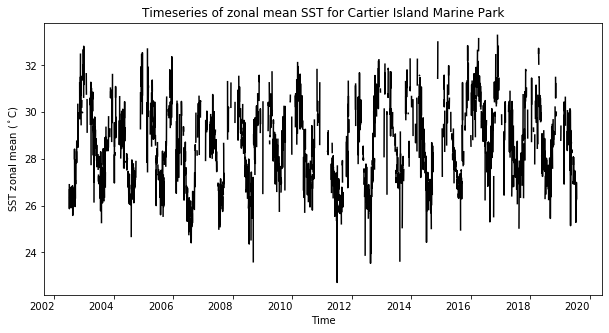

In [14]:
plt.figure(figsize=(10,5))
MODIS_data_cleaned.sst_mean.plot(color='k');
plt.xticks(rotation='horizontal');
plt.xlabel('Time');
plt.ylabel('SST zonal mean ($^\circ$C)');
plt.title('Timeseries of zonal mean SST for ' + AMP_name + ' Marine Park');

## Apply interpolation using the pad function to the daily mean, min, max and std SST time-series

In [15]:
MODIS_data_cleaned['sst_mean_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_mean'].values,maxPadLength=False), 
                                                     dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['sst_min_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_min'].values,maxPadLength=False), 
                                                    dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['sst_max_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_max'].values,maxPadLength=False), 
                                                    dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['sst_std_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_std'].values,maxPadLength=False), 
                                                    dims='time', coords={'time': MODIS_data_cleaned['time']})

In [16]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:          (latitude: 14, longitude: 15, time: 6214)
Coordinates:
  * time             (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude         (latitude) float64 -12.47 -12.48 -12.49 ... -12.59 -12.6
  * longitude        (longitude) float64 123.5 123.5 123.5 ... 123.6 123.6 123.6
Data variables:
    sst              (time, latitude, longitude) float32 nan nan nan ... nan nan
    sst_mean         (time) float32 26.897036 25.869576 ... 26.299578 nan
    sst_min          (time) float32 26.605 25.425 26.38 ... 26.305 25.965 nan
    sst_max          (time) float32 27.24 26.31 27.03 nan ... 26.365 26.635 nan
    sst_std          (time) float32 0.14253645 0.18784189 ... 0.13139829 nan
    sst_mean_interp  (time) float32 26.897036 25.869576 ... 26.299578 26.299578
    sst_min_interp   (time) float32 26.605 25.425 26.38 ... 26.305 25.965 25.965
    sst_max_interp   (time) float32 27.24 26.31 27.03 ... 26.365 26.635 26.635
    sst_std_interp   (time) float32 0.14253645 0.18784189 ... 0.13139829
Attributes:
    crs:      EPSG:4326

### Plot the interploated daily SST mean, minimum and maximum time-series

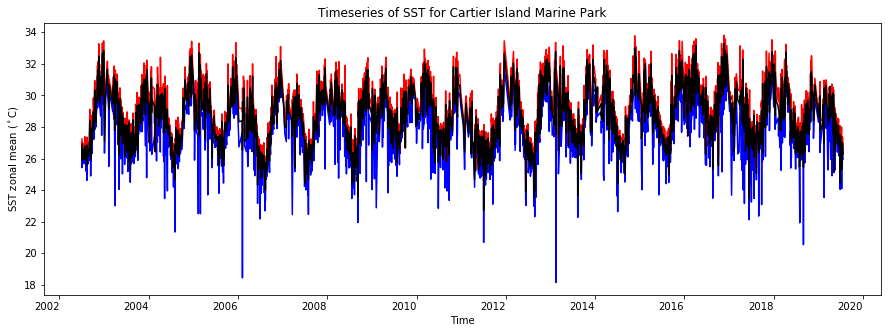

In [17]:
ax=plt.figure(figsize=(15,5))
MODIS_data_cleaned.sst_min_interp.plot(color='b');
MODIS_data_cleaned.sst_max_interp.plot(color='r');
MODIS_data_cleaned.sst_mean_interp.plot(color='k');
plt.xticks(rotation='horizontal');
plt.xlabel('Time');
plt.ylabel('SST zonal mean ($^\circ$C)');
plt.title('Timeseries of SST for ' + AMP_name + ' Marine Park');

## Calculate SST monthly, seaonal and yearly time-series, and annual warming rates

### Fit a linear trend line to the interpolated daily mean SST time-series

The slope indicates the daily warming rate. Note that the `sm.ols` function requires the data to apply the fit to as one input, and an index associated with that data as the other, not the actual `time` variable. To achieve this, we input `range(1,len(time)+1)`. Note that it's `+1` as the interp drops one time step, so we need to add an extra index to the input.  

In [18]:
# Applies an ordinary least squares regression
meanFit_daily = sm.ols(formula='sst_mean_interp.values ~ range(1,len(time)+1)',
                 data=MODIS_data_cleaned).fit()
print(meanFit_daily.summary())

                              OLS Regression Results                              
Dep. Variable:     sst_mean_interp.values   R-squared:                       0.011
Model:                                OLS   Adj. R-squared:                  0.011
Method:                     Least Squares   F-statistic:                     71.87
Date:                    Tue, 19 May 2020   Prob (F-statistic):           2.84e-17
Time:                            12:30:03   Log-Likelihood:                -11689.
No. Observations:                    6214   AIC:                         2.338e+04
Df Residuals:                        6212   BIC:                         2.340e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

#### Plot the data with the calculated trendline

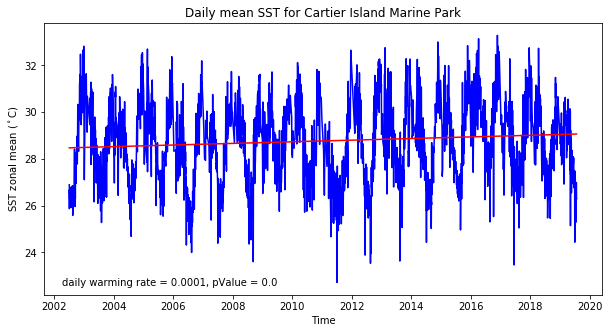

In [19]:
# Fit the trendline to the data
predict_daily = meanFit_daily.predict(MODIS_data_cleaned)

# obtain the warming rate (slope of the trend line) and pValue (indication of the statistical significance)
rate = round(meanFit_daily.params[1], 4)
pValue = round(meanFit_daily.pvalues[1], 4)

ax = plt.figure(figsize=(10, 5))
plt.plot(MODIS_data_cleaned.time, MODIS_data_cleaned.sst_mean_interp, 'b')
plt.plot(MODIS_data_cleaned.time, predict_daily, 'r')

ax.text(0.15,
        0.15,
        f'daily warming rate = {str(rate)}, pValue = {str(pValue)}',
        fontsize=10)

plt.xlabel('Time')
plt.ylabel('SST zonal mean ($^\circ$C)')
plt.title('Daily mean SST for ' + AMP_name + ' Marine Park');

### Plot and fit a linear trend line to the mean annual time-series

The warming rate calculated is the annual warming rate. Note that the years 2002 and 2019 are partial years and should be excluded.

In [20]:
MODIS_annual_mean_sst = MODIS_data_cleaned.sst_mean.groupby('time.year').mean()

Drop off the partial years 2002 and 2019

In [21]:
MODIS_annual_mean_sst = MODIS_annual_mean_sst.sel(year=slice('2003', '2018'))

#### Fit a linear trend line to the interpolated daily mean SST time-series

The slope indicates the annual warming rate. 

In [22]:
# Applies an ordinary least squares regression
meanFit_annual = sm.ols(formula='MODIS_annual_mean_sst.values ~ range(1,len(year)+1)',
                 data=MODIS_annual_mean_sst).fit()
print(meanFit_annual.summary())

                                 OLS Regression Results                                 
Dep. Variable:     MODIS_annual_mean_sst.values   R-squared:                       0.150
Model:                                      OLS   Adj. R-squared:                  0.089
Method:                           Least Squares   F-statistic:                     2.472
Date:                          Tue, 19 May 2020   Prob (F-statistic):              0.138
Time:                                  12:30:03   Log-Likelihood:                -11.230
No. Observations:                            16   AIC:                             26.46
Df Residuals:                                14   BIC:                             28.01
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


#### Plot the data with the calculated trendline

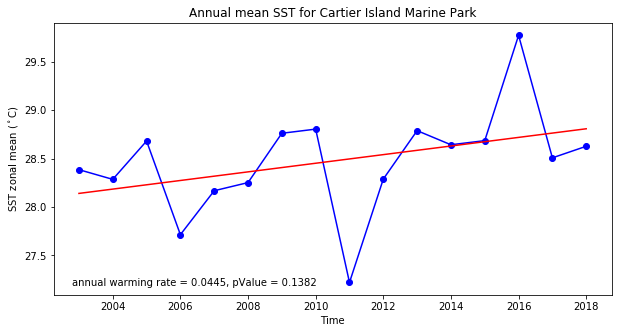

In [23]:
# Fit the trendline to the data
predict_annual = meanFit_annual.predict(MODIS_annual_mean_sst)

# obtain the warming rate (slope of the trend line) and pValue (indication of the statistical significance)
rate = round(meanFit_annual.params[1], 4)
pValue = round(meanFit_annual.pvalues[1], 4)

ax = plt.figure(figsize=(10, 5))
plt.plot(MODIS_annual_mean_sst.year, MODIS_annual_mean_sst, '-ob')
plt.plot(MODIS_annual_mean_sst.year, predict_annual, 'r')

ax.text(0.15,
        0.15,
        f'annual warming rate = {str(rate)}, pValue = {str(pValue)}',
        fontsize=10)

plt.xlabel('Time')
plt.ylabel('SST zonal mean ($^\circ$C)')
plt.title('Annual mean SST for ' + AMP_name + ' Marine Park');

## Plot annual mean SST with temporal variance and mean spatial variance as error bars

Here, the temporal mean is std of 365 daily mean SST values. The spatial mean is the mean of 365 daily std SST values.

In [24]:
spatial_mean_ann = MODIS_data_cleaned.sst_std.groupby('time.year').mean()
temporal_mean_ann = MODIS_data_cleaned.sst_mean.groupby('time.year').std()

Drop off the partial years 2002 and 2019

In [25]:
temporal_mean_ann = temporal_mean_ann.sel(year=slice('2003', '2018'))
spatial_mean_ann = spatial_mean_ann.sel(year=slice('2003', '2018'))

#### Plot the data with the error bars

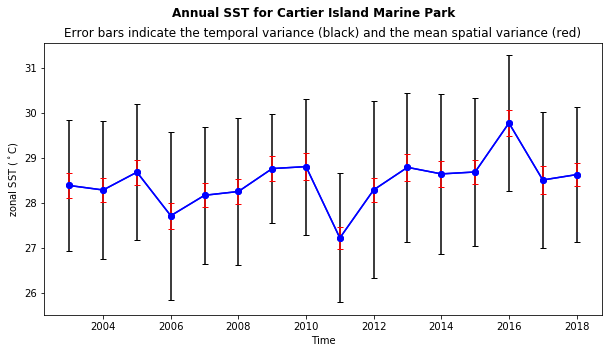

In [26]:
ax = plt.figure(figsize=(10, 5))
plt.errorbar(MODIS_annual_mean_sst.year, MODIS_annual_mean_sst, yerr= temporal_mean_ann, 
             ecolor='k', capsize=3, color='b', marker='o')
plt.errorbar(MODIS_annual_mean_sst.year, MODIS_annual_mean_sst, yerr= spatial_mean_ann, 
             ecolor='r', capsize=3, color='b', marker='o')
plt.xlabel('Time')
plt.ylabel('zonal SST ($^\circ$C)')
plt.suptitle('Annual SST for ' + AMP_name + ' Marine Park', fontweight='bold');
plt.title('Error bars indicate the temporal variance (black) and the mean spatial variance (red)');

### Now do the same for the monthly data

In [27]:
# Calculate the monthly mean SST
MODIS_monthly_mean_sst = MODIS_data_cleaned.sst_mean.groupby('time.month').mean()

spatial_mean_mon = MODIS_data_cleaned.sst_std.groupby('time.month').mean()
temporal_mean_mon = MODIS_data_cleaned.sst_mean.groupby('time.month').std()

#### Plot the data with the std error bars

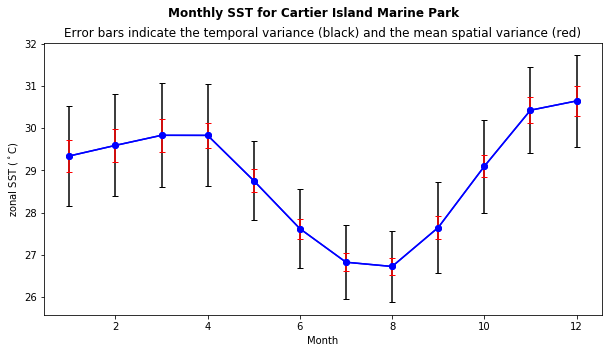

In [28]:
ax = plt.figure(figsize=(10, 5))
plt.errorbar(MODIS_monthly_mean_sst.month, MODIS_monthly_mean_sst, yerr= temporal_mean_mon, 
             ecolor='k', capsize=3, color='b', marker='o')
plt.errorbar(MODIS_monthly_mean_sst.month, MODIS_monthly_mean_sst, yerr= spatial_mean_mon, 
             ecolor='r', capsize=3, color='b', marker='o')
plt.xlabel('Month')
plt.ylabel('zonal SST ($^\circ$C)')
plt.suptitle('Monthly SST for ' + AMP_name + ' Marine Park', fontweight='bold');
plt.title('Error bars indicate the temporal variance (black) and the mean spatial variance (red)');

## Calculate annual time-series of seasonal statistics (mean, std, etc) using the interpolated data

Here we are using the 3 monthly mean values of zonal mean, interpolated SST to aggregate to seasonal values for each year. 

In [29]:
# Resample into 3 monthly/seasonal means
MODIS_season_mean_sst = MODIS_data_cleaned.sst_mean_interp.resample(time='QS-DEC', label='left').mean()

The first season in 2002 and the last season in 2019 are not complete and should be excluded

In [30]:
MODIS_season_mean_sst = MODIS_season_mean_sst.sel(time=slice('09-2002', '05-2019'))

Now tag each month with the season it belongs to: 1 = summer, 2 = autumn, 3 = winter, 4 = spring

In [31]:
MODIS_season_mean_sst['season'] = (MODIS_season_mean_sst.time.dt.month%12 + 3)//3

In [32]:
MODIS_season_mean_sst

<xarray.DataArray 'sst_mean_interp' (time: 67)>
array([28.92194 , 30.419363, 29.297113, 27.156935, 28.474987, 29.372883,
       29.10799 , 26.907866, 28.78077 , 29.992525, 29.571005, 27.246153,
       28.903233, 29.237537, 28.48344 , 25.883312, 28.56428 , 29.590166,
       28.785524, 26.695772, 28.797777, 29.708405, 29.429625, 26.562733,
       29.219738, 28.886852, 29.529482, 27.67501 , 29.455797, 29.453568,
       29.75244 , 27.515078, 28.888159, 29.109863, 27.401705, 26.261677,
       28.081657, 30.649841, 29.288948, 26.354445, 29.501307, 30.294176,
       29.441406, 27.612337, 29.023003, 29.67767 , 29.967161, 27.078283,
       29.166285, 29.899843, 29.433891, 27.115389, 29.445816, 30.244255,
       30.664427, 28.420435, 30.078245, 29.795784, 29.428658, 27.222195,
       29.076523, 30.13958 , 29.78236 , 27.274029, 28.802298, 29.12911 ,
       29.100328], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-09-01 2002-12-01 ... 2019-03-01
    season   (time) int64 4 1 2 3 4 1 2 3 4 1 2 3 4 ... 3 4 1 2 3 4 1 2 3 4 1 2

#### Fit a linear trend line to the annual time-series of seasonal mean (Spring in this case)

The warming rate is the annual warming rate for the season

In [33]:
MODIS_spring = MODIS_season_mean_sst[MODIS_season_mean_sst.season == 4]

In [34]:
# Applies an ordinary least squares regression
meanFit_spring = sm.ols(formula='MODIS_spring.values ~ range(1,len(time)+1)',
                 data=MODIS_spring).fit()
print(meanFit_spring.summary())

                             OLS Regression Results                            
Dep. Variable:     MODIS_spring.values   R-squared:                       0.187
Model:                             OLS   Adj. R-squared:                  0.133
Method:                  Least Squares   F-statistic:                     3.450
Date:                 Tue, 19 May 2020   Prob (F-statistic):             0.0830
Time:                         12:30:05   Log-Likelihood:                -8.5958
No. Observations:                   17   AIC:                             21.19
Df Residuals:                       15   BIC:                             22.86
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


#### Plot the data with the calculated trendline

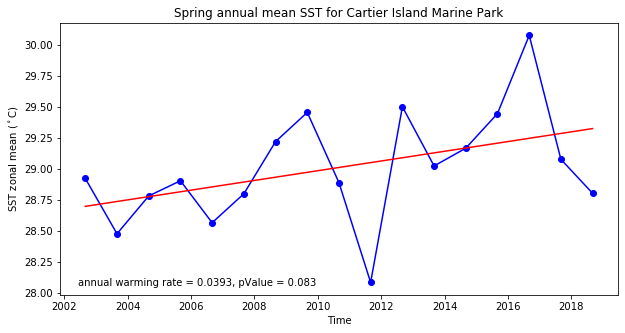

In [35]:
# Fit the trendline to the data
predict_spring = meanFit_spring.predict(MODIS_spring)

# obtain the warming rate (slope of the trend line) and pValue (indication of the statistical significance)
rate = round(meanFit_spring.params[1], 4)
pValue = round(meanFit_spring.pvalues[1], 4)

ax = plt.figure(figsize=(10, 5))
plt.plot(MODIS_spring.time, MODIS_spring, '-ob')
plt.plot(MODIS_spring.time, predict_spring, 'r')

ax.text(0.15,
        0.15,
        f'annual warming rate = {str(rate)}, pValue = {str(pValue)}',
        fontsize=10)

plt.xlabel('Time')
plt.ylabel('SST zonal mean ($^\circ$C)')
plt.title('Spring annual mean SST for ' + AMP_name + ' Marine Park');

## Identify extreme hot days

A extreme hot day is defined as a day with a SST greater than the 95% percentile of the whole time-series (all days in all years)

In [36]:
# get 95% percentile of the entire time-series
p95 = MODIS_data_cleaned['sst_mean_interp'].quantile(0.95) 

In [37]:
# Find days with a mean zonal SST greater than the 95th percentile
hot_days = MODIS_data_cleaned['sst_mean_interp'][MODIS_data_cleaned['sst_mean_interp'] >= p95]

In [38]:
# Count the number of hot days per year
hot_days_yearly = hot_days.groupby('time.year').count()
# Drop 2002 and 2019 
hot_days_yearly = hot_days_yearly.sel(year=slice('2003', '2018'))

### Plot and fit a linear trend line to the annual time-series of number of extreme hot days

In [39]:
# Applies an ordinary least squares regression
meanFit_hot = sm.ols(formula='hot_days_yearly.values ~ range(1,len(year)+1)',
                 data=hot_days_yearly).fit()
print(meanFit_hot.summary())

                              OLS Regression Results                              
Dep. Variable:     hot_days_yearly.values   R-squared:                       0.348
Model:                                OLS   Adj. R-squared:                  0.302
Method:                     Least Squares   F-statistic:                     7.484
Date:                    Tue, 19 May 2020   Prob (F-statistic):             0.0161
Time:                            12:30:05   Log-Likelihood:                -62.347
No. Observations:                      16   AIC:                             128.7
Df Residuals:                          14   BIC:                             130.2
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


#### Plot the data with the calculated trendline

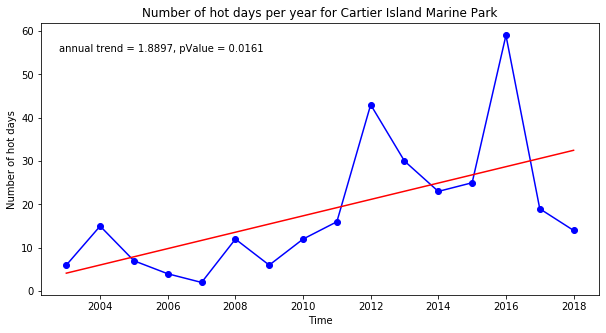

In [40]:
# Fit the trendline to the data
predict_hot = meanFit_hot.predict(hot_days_yearly)

# obtain the warming rate (slope of the trend line) and pValue (indication of the statistical significance)
rate = round(meanFit_hot.params[1], 4)
pValue = round(meanFit_hot.pvalues[1], 4)

ax = plt.figure(figsize=(10, 5))
plt.plot(hot_days_yearly.year, hot_days_yearly, '-ob')
plt.plot(hot_days_yearly.year, predict_hot, 'r')

ax.text(0.15,
        0.8,
        f'annual trend = {str(rate)}, pValue = {str(pValue)}',
        fontsize=10)

plt.xlabel('Time')
plt.ylabel('Number of hot days')
plt.title('Number of hot days per year for ' + AMP_name + ' Marine Park');

## Calculate per-pixel SST long-term means, seasonal means, monthly means and warming rates

### calculate per-pixel annual mean SST values

The pixel_SST_ann dataset contains annual SST information: mean, warming rate, observation frequency, etc

In [41]:
pixel_SST_ann = MODIS_data_cleaned.sst.groupby('time.year').mean()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Years 2002 and 2019 are partial years and thus should be excluded

In [42]:
pixel_SST_ann = pixel_SST_ann.sel(year=slice('2003', '2018'))
# Convert to a dataset so we can append to it later on
pixel_SST_ann = xr.Dataset(data_vars={'sst_ann': pixel_SST_ann})

In [43]:
pixel_SST_ann

<xarray.Dataset>
Dimensions:    (latitude: 14, longitude: 15, year: 16)
Coordinates:
  * latitude   (latitude) float64 -12.47 -12.48 -12.49 ... -12.58 -12.59 -12.6
  * longitude  (longitude) float64 123.5 123.5 123.5 123.5 ... 123.6 123.6 123.6
  * year       (year) int64 2003 2004 2005 2006 2007 ... 2015 2016 2017 2018
Data variables:
    sst_ann    (year, latitude, longitude) float32 nan nan nan ... nan nan nan

### Calculate and display per-pixel annual warming rates

For each pixel, we want to apply the least squares fit to the annual mean SST, and capture the rate and pValue of the result. We then feed these back into our xarray dataset (pixel_SST_ann).

In [44]:
# Create an empty dataset to put our values into
pixel_SST_ann['pValue'] = xr.DataArray(data=np.nan * pixel_SST_ann['latitude'] *
                                       pixel_SST_ann['longitude'],
                                       coords={
                                           'latitude': pixel_SST_ann['latitude'],
                                           'longitude': pixel_SST_ann['longitude']
                                       })
pixel_SST_ann['warming_rate'] = xr.DataArray(data=np.nan * pixel_SST_ann['latitude'] *
                                       pixel_SST_ann['longitude'],
                                       coords={
                                           'latitude': pixel_SST_ann['latitude'],
                                           'longitude': pixel_SST_ann['longitude']
                                       })
pixel_SST_ann['observation_frequency'] = xr.DataArray(data=np.nan * pixel_SST_ann['latitude'] *
                                       pixel_SST_ann['longitude'],
                                       coords={
                                           'latitude': pixel_SST_ann['latitude'],
                                           'longitude': pixel_SST_ann['longitude']
                                       })

In [45]:
# Loop through each lat/lon and calculate the rate of warming
# Calculate the rate,pValue and observation frequency; and add to the pixel_SST_ann dataset
for iix, i in enumerate(pixel_SST_ann.latitude):
    for jix, j in enumerate(pixel_SST_ann.longitude):
        try:
            meanFit_loop = sm.ols(formula='sst_ann[:,iix,jix].values ~ range(1,len(year)+1)', data=pixel_SST_ann).fit()
            # Fit the trendline to the data
            predict_loop = meanFit_loop.predict(pixel_SST_ann)
            # obtain the warming rate (slope of the trend line) 
            # and pValue (indication of the statistical significance)
            # observation frequency indicates the uncertainty
            pixel_SST_ann['warming_rate'][iix, jix] = round(meanFit_loop.params[1], 3)
            pixel_SST_ann['pValue'][iix, jix] = round(meanFit_loop.pvalues[1], 2)
            # index range 173:6011 represents 2003-01-01 to 2018-12-31 inclusive
            freq = (MODIS_data_cleaned.sst[173:6011,iix,jix].count()/MODIS_data_cleaned.sst[173:6011,iix,jix].size).item()
            pixel_SST_ann['observation_frequency'][iix, jix] = round(freq, 2)
        except ValueError:
            continue

In [46]:
MODIS_data_cleaned.sst[173:6011].time

<xarray.DataArray 'time' (time: 5838)>
array(['2003-01-01T11:59:59.999999000', '2003-01-02T11:59:59.999999000',
       '2003-01-03T11:59:59.999999000', ..., '2018-12-29T11:59:59.999999000',
       '2018-12-30T11:59:59.999999000', '2018-12-31T11:59:59.999999000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T11:59:59.999999 ... 2018-12-31T11:59:59.999999
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [47]:
pixel_SST_ann

<xarray.Dataset>
Dimensions:                (latitude: 14, longitude: 15, year: 16)
Coordinates:
  * latitude               (latitude) float64 -12.47 -12.48 ... -12.59 -12.6
  * longitude              (longitude) float64 123.5 123.5 123.5 ... 123.6 123.6
  * year                   (year) int64 2003 2004 2005 2006 ... 2016 2017 2018
Data variables:
    sst_ann                (year, latitude, longitude) float32 nan nan ... nan
    pValue                 (latitude, longitude) float64 nan nan nan ... nan nan
    warming_rate           (latitude, longitude) float64 nan nan nan ... nan nan
    observation_frequency  (latitude, longitude) float64 nan nan nan ... nan nan

#### Display the annual warming rate

<Figure size 576x504 with 0 Axes>

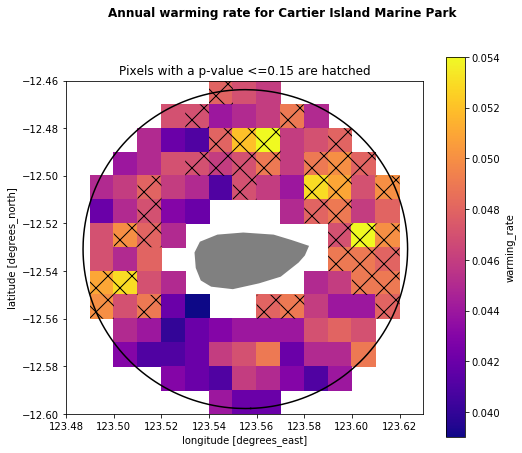

In [48]:
width = 8
height = round(width * h_w_ratio)

plt.figure(figsize=(width,height))
if os.path.exists(reefs_islands_shp): 
    # plot the islands/reefs
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(figsize=(width,height),color='gray')

# plot the marine park outline
plt.plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
pixel_SST_ann.warming_rate.plot(cmap='plasma');
# only highlight data points where pValue <= 0.15, representing significance level >= 85%
significance = pixel_SST_ann.pValue.where(pixel_SST_ann.pValue <= 0.15)
# We need to use the pcolor library to hatch over the significant cells
# pcolor plots the data at the midpoint of the coordinates, so we need to offset it
# so that it's inline with the rest of the plot
# note that the dimensions of X and Y should be one greater than those of C (significance.values in this case). 
# If X, Y and C have equal dimensions, in which case the last row and column of C will be ignored.
offsetx = (significance.longitude[1] - significance.longitude[0]) / 2
offsety = (significance.latitude[1] - significance.latitude[0]) / 2
x = (significance.longitude - offsetx).values
x=np.insert(x,x.size,x[x.size-1]+2*offsetx)
y = (significance.latitude - offsety).values
y=np.insert(y,y.size,y[y.size-1]+2*offsety)
plt.pcolor(x, y, significance.values, hatch='X', alpha=0.);
plt.suptitle('Annual warming rate for ' + AMP_name + ' Marine Park', fontweight='bold');
plt.title('Pixels with a p-value <=0.15 are hatched');

### Calulate and display per-pixel long-term SST means

The pixel_SST_overall dataset contains the long-term mean (std) SST values for each pixel, as well as the observation frequency

In [49]:
long_term_mean = MODIS_data_cleaned.sst.mean(dim='time')
long_term_std = MODIS_data_cleaned.sst.std(dim='time')
freq = MODIS_data_cleaned.sst.count(dim='time')/MODIS_data_cleaned.sst.time.size
pixel_SST_overall = xr.Dataset(data_vars={'sst_mean': long_term_mean,'sst_std': long_term_std,'observation_frequency': freq})

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [50]:
pixel_SST_overall

<xarray.Dataset>
Dimensions:                (latitude: 14, longitude: 15)
Coordinates:
  * latitude               (latitude) float64 -12.47 -12.48 ... -12.59 -12.6
  * longitude              (longitude) float64 123.5 123.5 123.5 ... 123.6 123.6
Data variables:
    sst_mean               (latitude, longitude) float32 nan nan nan ... nan nan
    sst_std                (latitude, longitude) float32 nan nan nan ... nan nan
    observation_frequency  (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0

#### plot the spatial distribution of the SST long-term mean; the hatched pixels have observation frequency >= 30% of the time-series

<Figure size 576x504 with 0 Axes>

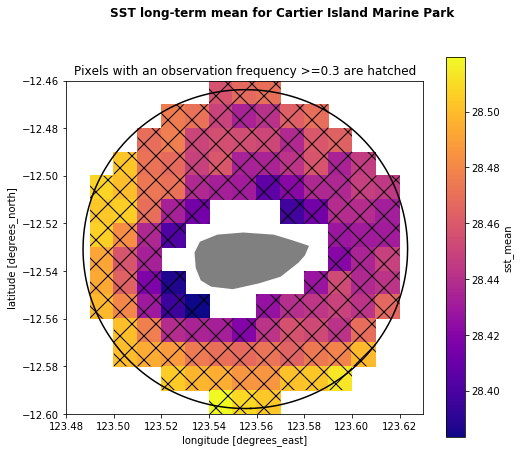

In [51]:
width = 8
height = round(width * h_w_ratio)

plt.figure(figsize=(width,height))
if os.path.exists(reefs_islands_shp): 
    # plot the islands/reefs
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(figsize=(width,height),color='gray')

# plot the marine park outline
plt.plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
pixel_SST_overall.sst_mean.plot(cmap='plasma');
# only highlight data points where observation frequency >= 0.3
significance = pixel_SST_overall.observation_frequency.where(pixel_SST_overall.observation_frequency >= 0.3)
# We need to use the pcolor library to hatch over the significant cells
# pcolor plots the data at the midpoint of the coordinates, so we need to offset it
# so that it's inline with the rest of the plot
# note that The dimensions of X and Y should be one greater than those of C (significance.values in this case). 
# If X, Y and C have equal dimensions, in which case the last row and column of C will be ignored.
offsetx = (significance.longitude[1] - significance.longitude[0]) / 2
offsety = (significance.latitude[1] - significance.latitude[0]) / 2
x = (significance.longitude - offsetx).values
x=np.insert(x,x.size,x[x.size-1]+2*offsetx)
y = (significance.latitude - offsety).values
y=np.insert(y,y.size,y[y.size-1]+2*offsety)
plt.pcolor(x, y, significance.values, hatch='X', alpha=0.);
plt.suptitle('SST long-term mean for ' + AMP_name + ' Marine Park', fontweight='bold');
plt.title('Pixels with an observation frequency >=0.3 are hatched');

### Calculate and display per-pixel seasonal SST means

The pixel_SST_season dataset holds all the seasonal information: mean, observation frequency, warming rate, etc

In [52]:
# the 2002 and 2019 winter seasons must be excluded, as they are incomplete
pixel_SST_season = MODIS_data_cleaned.sel(time=slice('09-2002', '05-2019'))

pixel_SST_season = pixel_SST_season.assign_coords(season=(pixel_SST_season.time.dt.month%12 + 3)//3)
# set multiple index; the time dimension now has two indices: time_level_0: the original time, 
# season: the new season index
pixel_SST_season=pixel_SST_season.set_index(time='season',append=True)
# only the SST data is needed
pixel_SST_season = pixel_SST_season.get(['sst'])

In [53]:
# calculate the seasonal means and observation frequencies
pixel_SST_season['spring_mean'] = pixel_SST_season.sel(season=4).sst.mean(dim='time_level_0')
pixel_SST_season['spring_observation_frequency'] = pixel_SST_season.sel(season=4).sst.count(dim='time_level_0')/pixel_SST_season.sel(season=4).time_level_0.size

pixel_SST_season['winter_mean'] = pixel_SST_season.sel(season=3).sst.mean(dim='time_level_0')
pixel_SST_season['winter_observation_frequency'] = pixel_SST_season.sel(season=3).sst.count(dim='time_level_0')/pixel_SST_season.sel(season=3).time_level_0.size

pixel_SST_season['autumn_mean'] = pixel_SST_season.sel(season=2).sst.mean(dim='time_level_0')
pixel_SST_season['autumn_observation_frequency'] = pixel_SST_season.sel(season=2).sst.count(dim='time_level_0')/pixel_SST_season.sel(season=2).time_level_0.size

pixel_SST_season['summer_mean'] = pixel_SST_season.sel(season=1).sst.mean(dim='time_level_0')
pixel_SST_season['summer_observation_frequency'] = pixel_SST_season.sel(season=1).sst.count(dim='time_level_0')/pixel_SST_season.sel(season=1).time_level_0.size

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### Display the seasonal means
The pixels with an observation frequency >= 0.3 are hatched

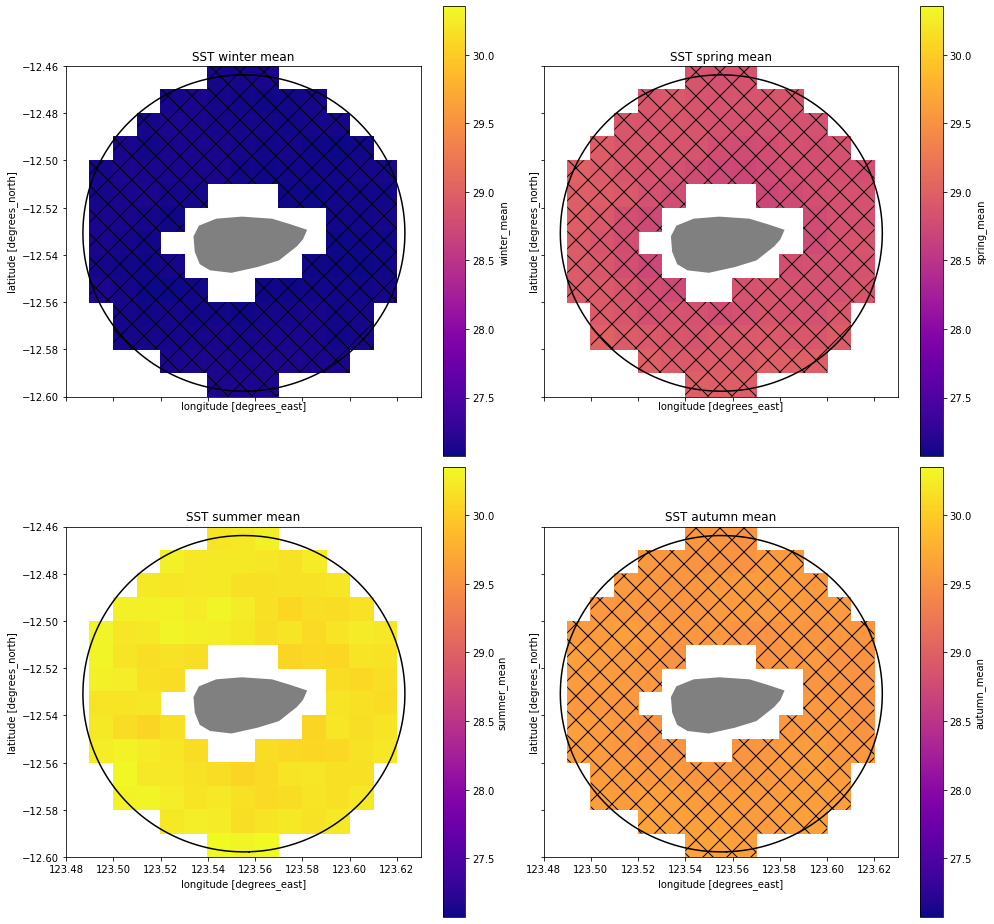

In [54]:
# the following codes obtain the minimum and maximum values in the time-series,
# and use them to set up the colormap
x=[pixel_SST_season['winter_mean'].min().values,pixel_SST_season['autumn_mean'].min().values,
  pixel_SST_season['summer_mean'].min().values,pixel_SST_season['spring_mean'].min().values]
minV = min(x)
x=[pixel_SST_season['winter_mean'].max().values,pixel_SST_season['autumn_mean'].max().values,
  pixel_SST_season['summer_mean'].max().values,pixel_SST_season['spring_mean'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'plasma'
if minV > 0:
    colormap = 'plasma'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

# four subplots
width = 14
height = round(width * h_w_ratio)
f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(width,height))

# winter
if os.path.exists(reefs_islands_shp):        
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=axes[0,0])
# plot the marine park outline
axes[0,0].plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
pixel_SST_season['winter_mean'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('SST winter mean')
# only highlight data points where observation frequency >= 0.3
significance = pixel_SST_season.winter_observation_frequency.where(pixel_SST_season.winter_observation_frequency >= 0.3)
# We need to use the pcolor library to hatch over the significant cells
# pcolor plots the data at the midpoint of the coordinates, so we need to offset it
# so that it's inline with the rest of the plot
# note that The dimensions of X and Y should be one greater than those of C (significance.values in this case). 
# If X, Y and C have equal dimensions, in which case the last row and column of C will be ignored.
offsetx = (significance.longitude[1] - significance.longitude[0]) / 2
offsety = (significance.latitude[1] - significance.latitude[0]) / 2
x = (significance.longitude - offsetx).values
x=np.insert(x,x.size,x[x.size-1]+2*offsetx)
y = (significance.latitude - offsety).values
y=np.insert(y,y.size,y[y.size-1]+2*offsety)
axes[0,0].pcolor(x, y, significance.values, hatch='X', alpha=0.);

# spring
if os.path.exists(reefs_islands_shp):    
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=axes[0,1])
# plot the marine park outline
axes[0,1].plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
pixel_SST_season['spring_mean'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('SST spring mean')
# only highlight data points where observation frequency >= 0.3
significance = pixel_SST_season.spring_observation_frequency.where(pixel_SST_season.spring_observation_frequency >= 0.3)
axes[0,1].pcolor(x, y, significance.values, hatch='X', alpha=0.);

# summer
if os.path.exists(reefs_islands_shp):    
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=axes[1,0])
# plot the marine park outline
axes[1,0].plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
pixel_SST_season['summer_mean'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('SST summer mean')
# only highlight data points where observation frequency >= 0.3
significance = pixel_SST_season.summer_observation_frequency.where(pixel_SST_season.summer_observation_frequency >= 0.3)
axes[1,0].pcolor(x, y, significance.values, hatch='X', alpha=0.);

# autumn
if os.path.exists(reefs_islands_shp):    
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=axes[1,1])
# plot the marine park outline
axes[1,1].plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
pixel_SST_season['autumn_mean'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('SST autumn mean')
# only highlight data points where observation frequency >= 0.3
significance = pixel_SST_season.autumn_observation_frequency.where(pixel_SST_season.autumn_observation_frequency >= 0.3)
axes[1,1].pcolor(x, y, significance.values, hatch='X', alpha=0.);


f.tight_layout()    
plt.show()

### Calculate annual warming rate and pValue for each season

In [55]:
##### Create an empty dataset to put our values in to
pixel_SST_season['spring_pValue'] = xr.DataArray(data=np.nan * pixel_SST_season['latitude'] *
                                       pixel_SST_season['longitude'],
                                       coords={
                                           'latitude': pixel_SST_season['latitude'],
                                           'longitude': pixel_SST_season['longitude']
                                       })
pixel_SST_season['spring_warming_rate'] = xr.DataArray(data=np.nan * pixel_SST_season['latitude'] *
                                       pixel_SST_season['longitude'],
                                       coords={
                                           'latitude': pixel_SST_season['latitude'],
                                           'longitude': pixel_SST_season['longitude']
                                       })

pixel_SST_season['winter_pValue'] = xr.DataArray(data=np.nan * pixel_SST_season['latitude'] *
                                       pixel_SST_season['longitude'],
                                       coords={
                                           'latitude': pixel_SST_season['latitude'],
                                           'longitude': pixel_SST_season['longitude']
                                       })
pixel_SST_season['winter_warming_rate'] = xr.DataArray(data=np.nan * pixel_SST_season['latitude'] *
                                       pixel_SST_season['longitude'],
                                       coords={
                                           'latitude': pixel_SST_season['latitude'],
                                           'longitude': pixel_SST_season['longitude']
                                       })

pixel_SST_season['autumn_pValue'] = xr.DataArray(data=np.nan * pixel_SST_season['latitude'] *
                                       pixel_SST_season['longitude'],
                                       coords={
                                           'latitude': pixel_SST_season['latitude'],
                                           'longitude': pixel_SST_season['longitude']
                                       })
pixel_SST_season['autumn_warming_rate'] = xr.DataArray(data=np.nan * pixel_SST_season['latitude'] *
                                       pixel_SST_season['longitude'],
                                       coords={
                                           'latitude': pixel_SST_season['latitude'],
                                           'longitude': pixel_SST_season['longitude']
                                       })

pixel_SST_season['summer_pValue'] = xr.DataArray(data=np.nan * pixel_SST_season['latitude'] *
                                       pixel_SST_season['longitude'],
                                       coords={
                                           'latitude': pixel_SST_season['latitude'],
                                           'longitude': pixel_SST_season['longitude']
                                       })
pixel_SST_season['summer_warming_rate'] = xr.DataArray(data=np.nan * pixel_SST_season['latitude'] *
                                       pixel_SST_season['longitude'],
                                       coords={
                                           'latitude': pixel_SST_season['latitude'],
                                           'longitude': pixel_SST_season['longitude']
                                       })

In [56]:
# resample daily time-series to seasonal data
MODIS_selected = MODIS_data_cleaned.sel(time=slice('09-2002', '05-2019')).sst.resample(time='QS-DEC',label='left').mean()
MODIS_selected['season'] = (MODIS_selected.time.dt.month%12 + 3)//3

spring = MODIS_selected[MODIS_selected.season == 4]
# Loop through each lat/lon and calculate the rate of warming
# Calculate the rate and pValue and add to the pixel_SST_season dataset
for iix, i in enumerate(pixel_SST_season.latitude):
    for jix, j in enumerate(pixel_SST_season.longitude):
        try:
            meanFit_loop = sm.ols(formula='spring[:,iix,jix].values ~ range(1,spring.time.size+1)', data=pixel_SST_season).fit()
            # obtain the warming rate (slope of the trend line) 
            # and pValue (indication of the statistical significance)
            pixel_SST_season['spring_warming_rate'][iix, jix] = round(meanFit_loop.params[1], 3)
            pixel_SST_season['spring_pValue'][iix, jix] = round(meanFit_loop.pvalues[1], 2)
           
        except ValueError:
            continue

winter = MODIS_selected[MODIS_selected.season == 3]
# Loop through each lat/lon and calculate the rate of warming
# Calculate the rate and pValue and add to the pixel_SST_season dataset
for iix, i in enumerate(pixel_SST_season.latitude):
    for jix, j in enumerate(pixel_SST_season.longitude):
        try:
            meanFit_loop = sm.ols(formula='winter[:,iix,jix].values ~ range(1,winter.time.size+1)', data=pixel_SST_season).fit()
            # obtain the warming rate (slope of the trend line) 
            # and pValue (indication of the statistical significance)
            pixel_SST_season['winter_warming_rate'][iix, jix] = round(meanFit_loop.params[1], 3)
            pixel_SST_season['winter_pValue'][iix, jix] = round(meanFit_loop.pvalues[1], 2)
           
        except ValueError:
            continue

autumn = MODIS_selected[MODIS_selected.season == 2]
# Loop through each lat/lon and calculate the rate of warming
# Calculate the rate and pValue and add to the pixel_SST_season dataset
for iix, i in enumerate(pixel_SST_season.latitude):
    for jix, j in enumerate(pixel_SST_season.longitude):
        try:
            meanFit_loop = sm.ols(formula='autumn[:,iix,jix].values ~ range(1,autumn.time.size+1)', data=pixel_SST_season).fit()
            # obtain the warming rate (slope of the trend line) 
            # and pValue (indication of the statistical significance)
            pixel_SST_season['autumn_warming_rate'][iix, jix] = round(meanFit_loop.params[1], 3)
            pixel_SST_season['autumn_pValue'][iix, jix] = round(meanFit_loop.pvalues[1], 2)
           
        except ValueError:
            continue
            
summer = MODIS_selected[MODIS_selected.season == 1]
# Loop through each lat/lon and calculate the rate of warming
# Calculate the rate and pValue and add to the pixel_SST_season dataset
for iix, i in enumerate(pixel_SST_season.latitude):
    for jix, j in enumerate(pixel_SST_season.longitude):
        try:
            meanFit_loop = sm.ols(formula='summer[:,iix,jix].values ~ range(1,summer.time.size+1)', data=pixel_SST_season).fit()
            # obtain the warming rate (slope of the trend line) 
            # and pValue (indication of the statistical significance)
            pixel_SST_season['summer_warming_rate'][iix, jix] = round(meanFit_loop.params[1], 3)
            pixel_SST_season['summer_pValue'][iix, jix] = round(meanFit_loop.pvalues[1], 2)
           
        except ValueError:
            continue            

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### Display annual warming rate for each season
The pixels with a pValue <= 0.1 are hatched

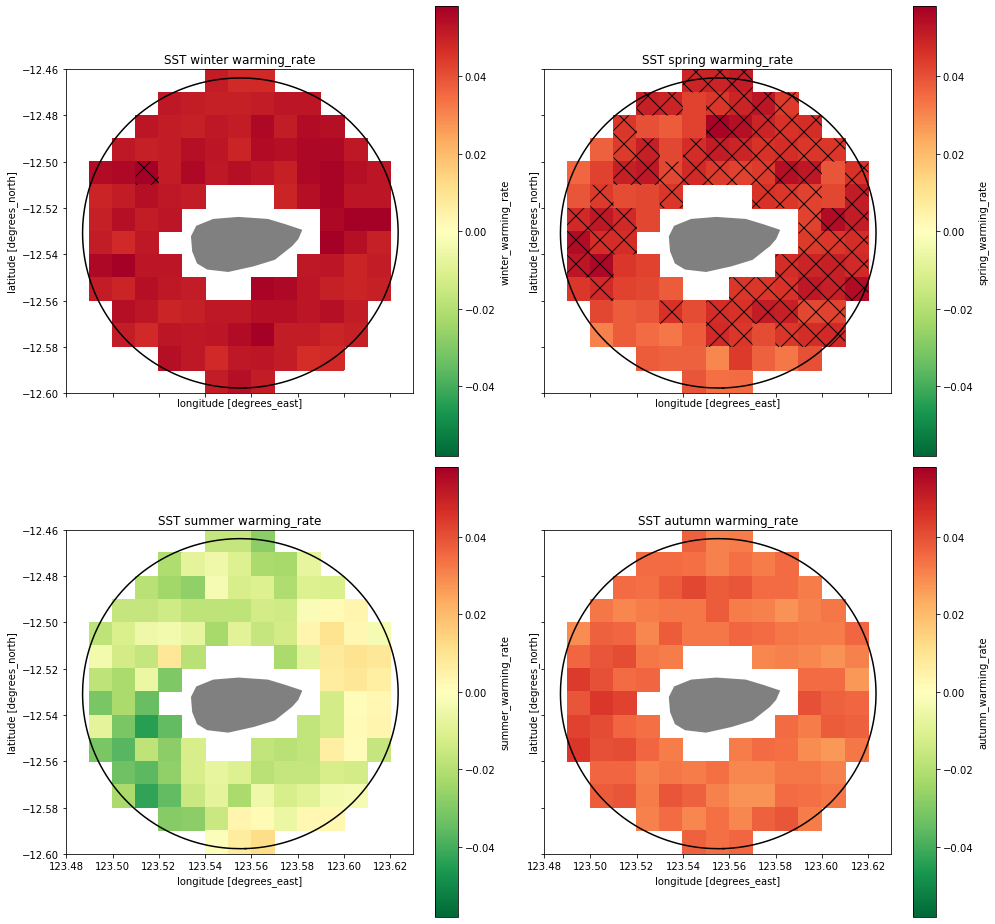

In [57]:
# the following codes obtain the minimum and maximum values in the time-series,
# and use them to set up the colormap
x=[pixel_SST_season['winter_warming_rate'].min().values,pixel_SST_season['autumn_warming_rate'].min().values,
  pixel_SST_season['summer_warming_rate'].min().values,pixel_SST_season['spring_warming_rate'].min().values]
minV = min(x)
x=[pixel_SST_season['winter_warming_rate'].max().values,pixel_SST_season['autumn_warming_rate'].max().values,
  pixel_SST_season['summer_warming_rate'].max().values,pixel_SST_season['spring_warming_rate'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'plasma'
if minV > 0:
    colormap = 'plasma'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

# four subplots
width = 14
height = round(width * h_w_ratio)
f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(width,height))

# winter
if os.path.exists(reefs_islands_shp):        
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=axes[0,0])
# plot the marine park outline
axes[0,0].plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
pixel_SST_season['winter_warming_rate'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('SST winter warming_rate')
# only highlight data points where pValue <= 0.1, representing 90% confidence level
significance = pixel_SST_season.winter_pValue.where(pixel_SST_season.winter_pValue <= 0.1)
# We need to use the pcolor library to hatch over the significant cells
# pcolor plots the data at the midpoint of the coordinates, so we need to offset it
# so that it's inline with the rest of the plot
# note that The dimensions of X and Y should be one greater than those of C (significance.values in this case). 
# If X, Y and C have equal dimensions, in which case the last row and column of C will be ignored.
offsetx = (significance.longitude[1] - significance.longitude[0]) / 2
offsety = (significance.latitude[1] - significance.latitude[0]) / 2
x = (significance.longitude - offsetx).values
x=np.insert(x,x.size,x[x.size-1]+2*offsetx)
y = (significance.latitude - offsety).values
y=np.insert(y,y.size,y[y.size-1]+2*offsety)
axes[0,0].pcolor(x, y, significance.values, 
           hatch='X', alpha=0.);

# spring
if os.path.exists(reefs_islands_shp):    
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=axes[0,1])
# plot the marine park outline
axes[0,1].plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
pixel_SST_season['spring_warming_rate'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('SST spring warming_rate')
# only highlight data points where pValue <= 0.1, representing 90% confidence level
significance = pixel_SST_season.spring_pValue.where(pixel_SST_season.spring_pValue <= 0.1)
axes[0,1].pcolor(x, y, significance.values, hatch='X', alpha=0.);

# summer
if os.path.exists(reefs_islands_shp):    
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=axes[1,0])
# plot the marine park outline
axes[1,0].plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
pixel_SST_season['summer_warming_rate'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('SST summer warming_rate')
# only highlight data points where pValue <= 0.1, representing 90% confidence level
significance = pixel_SST_season.summer_pValue.where(pixel_SST_season.summer_pValue <= 0.1)
axes[1,0].pcolor(x, y, significance.values, hatch='X', alpha=0.);

# autumn
if os.path.exists(reefs_islands_shp):    
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=axes[1,1])
# plot the marine park outline
axes[1,1].plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
pixel_SST_season['autumn_warming_rate'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('SST autumn warming_rate')
# only highlight data points where pValue <= 0.1, representing 90% confidence level
significance = pixel_SST_season.autumn_pValue.where(pixel_SST_season.autumn_pValue <= 0.1)
axes[1,1].pcolor(x, y, significance.values, hatch='X', alpha=0.);


f.tight_layout()    
plt.show()

### Calculate and display per-pixel monthly SST means

The pixel_SST_month dataset holds all the monthly information: mean, observation frequency, warming rate, etc

In [58]:
pixel_SST_month = MODIS_data_cleaned.assign_coords(month=MODIS_data_cleaned.time.dt.month)
pixel_SST_month=pixel_SST_month.set_index(time='month',append=True)
pixel_SST_month = pixel_SST_month.get(['sst'])

In [59]:
monList = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
i = 0
while i < 12:
    mon = monList[i]
    pixel_SST_month[mon + '_mean'] = pixel_SST_month.sel(month=i+1).sst.mean(dim='time_level_0')
    pixel_SST_month[mon + '_observation_frequency'] = pixel_SST_month.sel(month=i+1).sst.count(dim='time_level_0')/pixel_SST_month.sel(month=i+1).time_level_0.size
    i += 1

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [60]:
pixel_SST_month

<xarray.Dataset>
Dimensions:                    (latitude: 14, longitude: 15, time: 6214)
Coordinates:
  * time                       (time) MultiIndex
  - time_level_0               (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  - month                      (time) int64 7 7 7 7 7 7 7 7 ... 7 7 7 7 7 7 7 7
  * longitude                  (longitude) float64 123.5 123.5 ... 123.6 123.6
  * latitude                   (latitude) float64 -12.47 -12.48 ... -12.59 -12.6
Data variables:
    sst                        (time, latitude, longitude) float32 nan ... nan
    Jan_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Jan_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Feb_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Feb_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Mar_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Mar_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Apr_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Apr_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    May_mean                   (latitude, longitude) float32 nan nan ... nan nan
    May_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Jun_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Jun_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Jul_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Jul_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Aug_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Aug_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Sep_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Sep_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Oct_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Oct_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Nov_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Nov_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Dec_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Dec_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    crs:      EPSG:4326

#### Display the monthly means
The pixels with an observation frequency >= 0.3 are hatched

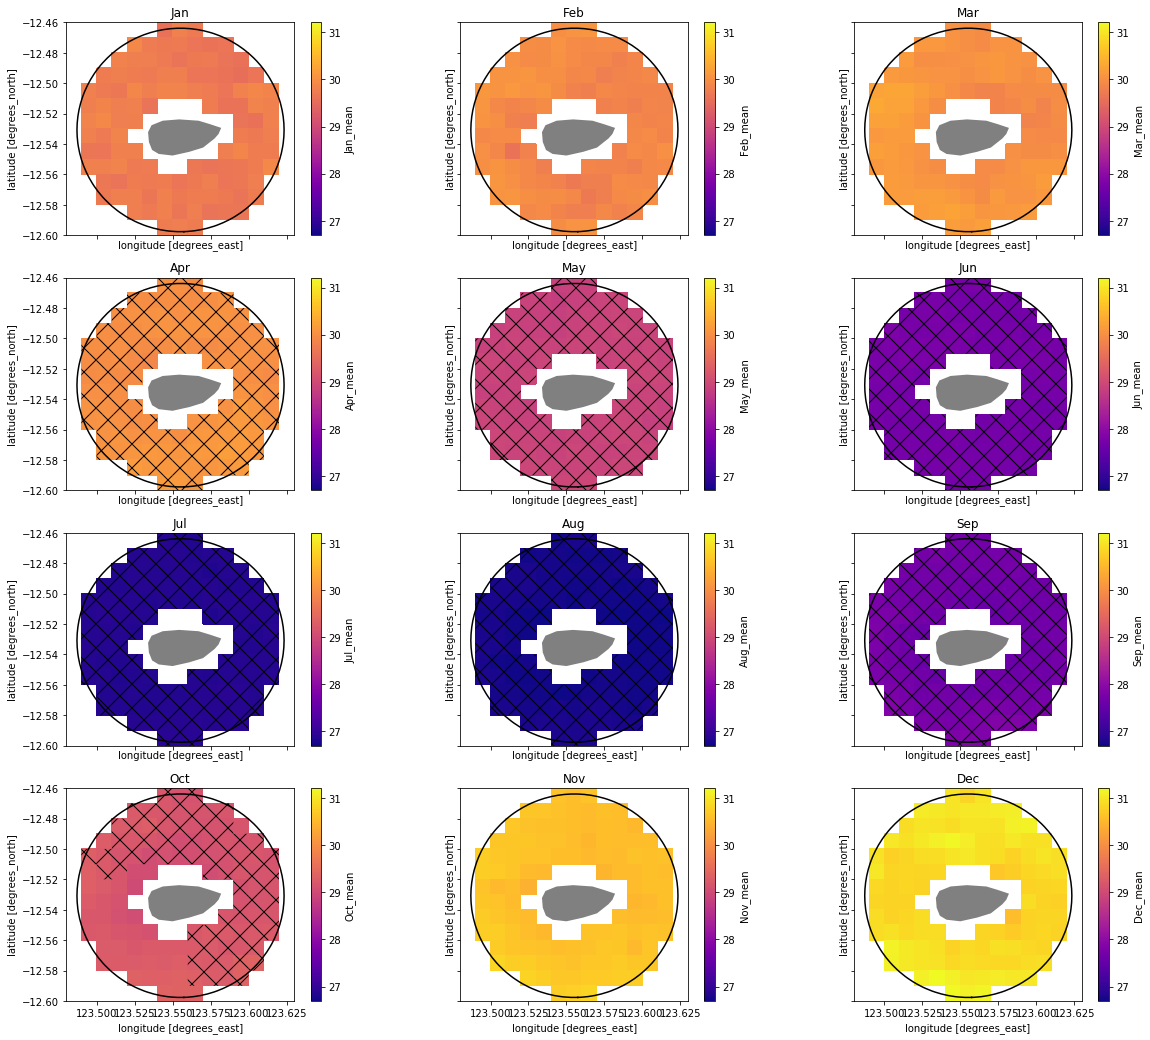

In [61]:
monList = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# the following codes obtain the minimum and maximum values in the time-series,
# and use them to set up the colormap
minList = []
maxList = []
for mon in monList:
    minList.append(pixel_SST_month[mon + '_mean'].min().values)
    maxList.append(pixel_SST_month[mon + '_mean'].max().values)
minV = min(minList)
maxV = max(maxList)

if maxV < 0:
    colormap = 'plasma'
if minV > 0:
    colormap = 'plasma'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

# 12 subplots, four rows, 3 columns, share x and y
width = 20
height = round(width * h_w_ratio)
f, axes = plt.subplots(4,3,sharex='all',sharey='all',figsize=(width,height))
# loop through each month to create the corresponding subplot
i = 0
k = 0
m = 0
while i < 12:    
    while k < 4:
        while m < 3:
            mon = monList[i]
            if os.path.exists(reefs_islands_shp):        
                shape_plot = gpd.read_file(reefs_islands_shp)
                shape_plot.plot(color='gray',ax=axes[k,m])
            # plot the marine park outline
            axes[k,m].plot(*AMP_polygon.exterior.xy, 'k');
            # plot the SST image
            pixel_SST_month[mon + '_mean'].plot(cmap=colormap,ax=axes[k,m],vmin=minV,vmax=maxV)
            axes[k,m].set_title(mon)
            # only highlight data points where observation frequency >= 0.3
            significance = pixel_SST_month[mon + '_observation_frequency'].where(pixel_SST_month[mon + '_observation_frequency'] >= 0.3)
            # We need to use the pcolor library to hatch over the significant cells
            # pcolor plots the data at the midpoint of the coordinates, so we need to offset it
            # so that it's inline with the rest of the plot
            # note that The dimensions of X and Y should be one greater than those of C (significance.values in this case). 
            # If X, Y and C have equal dimensions, in which case the last row and column of C will be ignored.
            offsetx = (significance.longitude[1] - significance.longitude[0]) / 2
            offsety = (significance.latitude[1] - significance.latitude[0]) / 2
            x = (significance.longitude - offsetx).values
            x=np.insert(x,x.size,x[x.size-1]+2*offsetx)
            y = (significance.latitude - offsety).values
            y=np.insert(y,y.size,y[y.size-1]+2*offsety)
            axes[k,m].pcolor(x, y, significance.values,hatch='X', alpha=0.)
            m += 1
            i += 1
        k += 1
        m = 0
    
                                



### Calculate annual warming rate and pValue for each month

In [62]:
monList = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for mon in monList:
    ##### Create an empty dataset to put our values in to
    pixel_SST_month[mon + '_pValue'] = xr.DataArray(data=np.nan * pixel_SST_month['latitude'] *
                                           pixel_SST_month['longitude'],
                                           coords={
                                               'latitude': pixel_SST_month['latitude'],
                                               'longitude': pixel_SST_month['longitude']
                                           })
    pixel_SST_month[mon + '_warming_rate'] = xr.DataArray(data=np.nan * pixel_SST_month['latitude'] *
                                           pixel_SST_month['longitude'],
                                           coords={
                                               'latitude': pixel_SST_month['latitude'],
                                               'longitude': pixel_SST_month['longitude']
                                           })

In [63]:
MODIS_selected = MODIS_data_cleaned.sst.resample(time='M').mean()
MODIS_selected['month'] = MODIS_selected.time.dt.month

monList = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
k=0
while k< 12:
    mon = monList[k]
    selected = MODIS_selected[MODIS_selected.month == k+1]
    # Loop through each lat/lon and calculate the rate of warming
    # Calculate the rate and pValue and add to the pixel_SST_month dataset
    for iix, i in enumerate(pixel_SST_month.latitude):
        for jix, j in enumerate(pixel_SST_month.longitude):
            try:
                meanFit_loop = sm.ols(formula='selected[:,iix,jix].values ~ range(1,selected.time.size+1)', data=pixel_SST_month).fit()
                # obtain the warming rate (slope of the trend line) 
                # and pValue (indication of the statistical significance)
                pixel_SST_month[mon+'_warming_rate'][iix, jix] = round(meanFit_loop.params[1], 3)
                pixel_SST_month[mon+'_pValue'][iix, jix] = round(meanFit_loop.pvalues[1], 2)

            except ValueError:
                continue
    k+=1

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [64]:
pixel_SST_month

<xarray.Dataset>
Dimensions:                    (latitude: 14, longitude: 15, time: 6214)
Coordinates:
  * time                       (time) MultiIndex
  - time_level_0               (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  - month                      (time) int64 7 7 7 7 7 7 7 7 ... 7 7 7 7 7 7 7 7
  * longitude                  (longitude) float64 123.5 123.5 ... 123.6 123.6
  * latitude                   (latitude) float64 -12.47 -12.48 ... -12.59 -12.6
Data variables:
    sst                        (time, latitude, longitude) float32 nan ... nan
    Jan_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Jan_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Feb_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Feb_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Mar_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Mar_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Apr_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Apr_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    May_mean                   (latitude, longitude) float32 nan nan ... nan nan
    May_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Jun_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Jun_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Jul_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Jul_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Aug_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Aug_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Sep_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Sep_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Oct_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Oct_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Nov_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Nov_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Dec_mean                   (latitude, longitude) float32 nan nan ... nan nan
    Dec_observation_frequency  (latitude, longitude) float64 0.0 0.0 ... 0.0 0.0
    Jan_pValue                 (latitude, longitude) float64 nan nan ... nan nan
    Jan_warming_rate           (latitude, longitude) float64 nan nan ... nan nan
    Feb_pValue                 (latitude, longitude) float64 nan nan ... nan nan
    Feb_warming_rate           (latitude, longitude) float64 nan nan ... nan nan
    Mar_pValue                 (latitude, longitude) float64 nan nan ... nan nan
    Mar_warming_rate           (latitude, longitude) float64 nan nan ... nan nan
    Apr_pValue                 (latitude, longitude) float64 nan nan ... nan nan
    Apr_warming_rate           (latitude, longitude) float64 nan nan ... nan nan
    May_pValue                 (latitude, longitude) float64 nan nan ... nan nan
    May_warming_rate           (latitude, longitude) float64 nan nan ... nan nan
    Jun_pValue                 (latitude, longitude) float64 nan nan ... nan nan
    Jun_warming_rate           (latitude, longitude) float64 nan nan ... nan nan
    Jul_pValue                 (latitude, longitude) float64 nan nan ... nan nan
    Jul_warming_rate           (latitude, longitude) float64 nan nan ... nan nan
    Aug_pValue                 (latitude, longitude) float64 nan nan ... nan nan
    Aug_warming_rate           (latitude, longitude) float64 nan nan ... nan nan
    Sep_pValue                 (latitude, longitude) float64 nan nan ... nan nan
    Sep_warming_rate           (latitude, longitude) float64 nan nan ... nan nan


#### Display annual warming rate for each month
The pixels with a pValue <= 0.1 are hatched

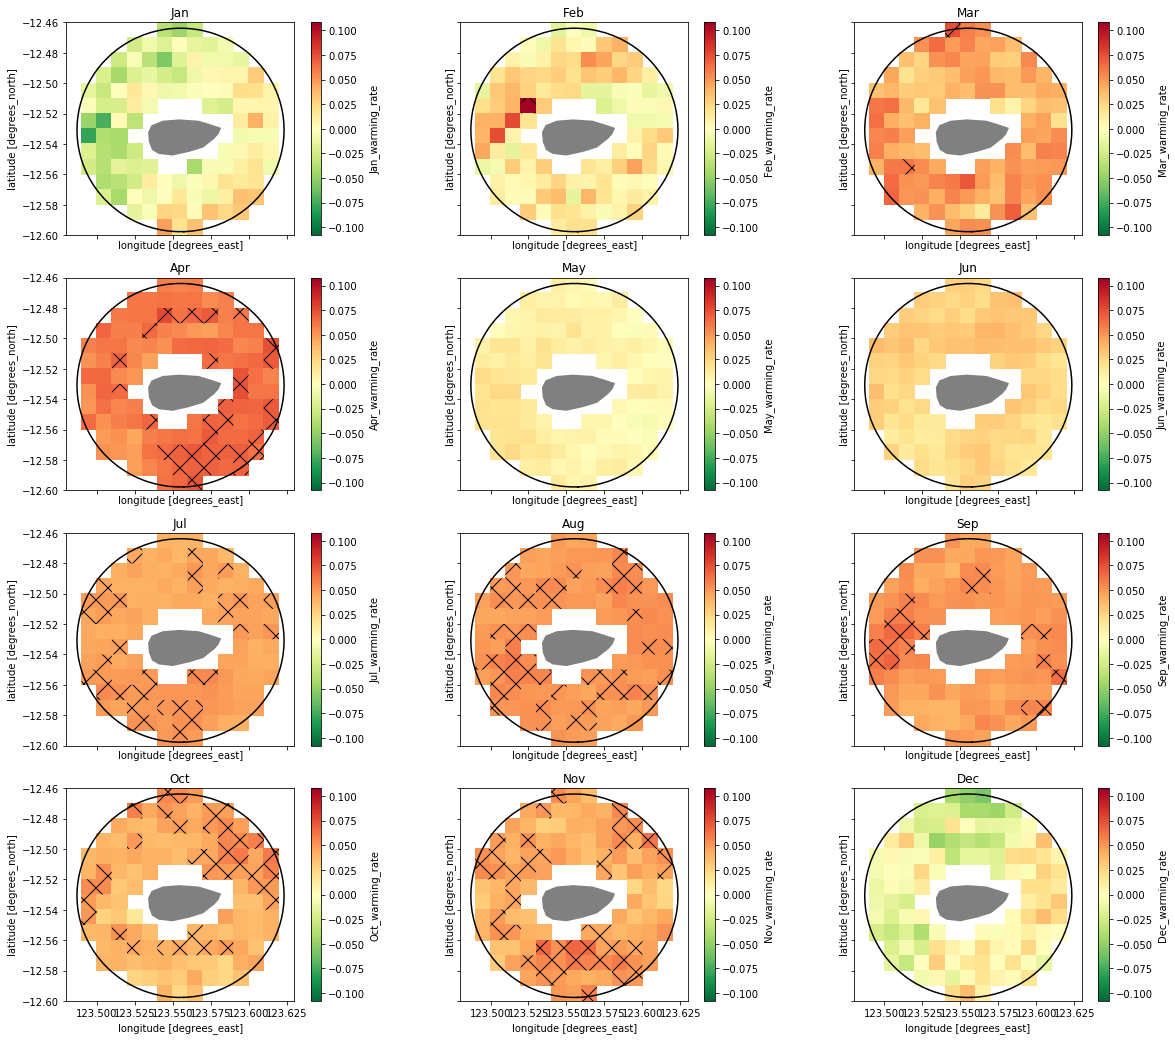

In [65]:
monList = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# the following codes obtain the minimum and maximum values in the time-series,
# and use them to set up the colormap
minList = []
maxList = []
for mon in monList:
    minList.append(pixel_SST_month[mon + '_warming_rate'].min().values)
    maxList.append(pixel_SST_month[mon + '_warming_rate'].max().values)
minV = min(minList)
maxV = max(maxList)

if maxV < 0:
    colormap = 'plasma'
if minV > 0:
    colormap = 'plasma'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

# 12 subplots, four rows, 3 columns, share x and y
width = 20
height = round(width * h_w_ratio)
f, axes = plt.subplots(4,3,sharex='all',sharey='all',figsize=(width,height))
# loop through each month to create the corresponding subplot
i = 0
k = 0
m = 0
while i < 12:    
    while k < 4:
        while m < 3:
            mon = monList[i]
            if os.path.exists(reefs_islands_shp):        
                shape_plot = gpd.read_file(reefs_islands_shp)
                shape_plot.plot(color='gray',ax=axes[k,m])
            # plot the marine park outline
            axes[k,m].plot(*AMP_polygon.exterior.xy, 'k');
            # plot the SST image
            pixel_SST_month[mon + '_warming_rate'].plot(cmap=colormap,ax=axes[k,m],vmin=minV,vmax=maxV)
            axes[k,m].set_title(mon)
            # only highlight data points where pValue <= 0.1
            significance = pixel_SST_month[mon + '_pValue'].where(pixel_SST_month[mon + '_pValue'] <= 0.1)
            # We need to use the pcolor library to hatch over the significant cells
            # pcolor plots the data at the midpoint of the coordinates, so we need to offset it
            # so that it's inline with the rest of the plot
            # note that The dimensions of X and Y should be one greater than those of C (significance.values in this case). 
            # If X, Y and C have equal dimensions, in which case the last row and column of C will be ignored.
            offsetx = (significance.longitude[1] - significance.longitude[0]) / 2
            offsety = (significance.latitude[1] - significance.latitude[0]) / 2
            x = (significance.longitude - offsetx).values
            x=np.insert(x,x.size,x[x.size-1]+2*offsetx)
            y = (significance.latitude - offsety).values
            y=np.insert(y,y.size,y[y.size-1]+2*offsety)
            axes[k,m].pcolor(x, y, significance.values,hatch='X', alpha=0.)
            m += 1
            i += 1
        k += 1
        m = 0
    

## Additional information
    
**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.
  
**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).
 
**Last modified:** May 2020
   
**Compatible datacube version:** 

In [66]:
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags

Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)